In [1]:
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms as tf
from os import walk
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import image
from torchvision import transforms
# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

In [2]:
train_df = pd.read_csv('train_df2.csv')
test_df = pd.read_csv('test_df2.csv')

In [3]:
train_df.sample(10)

,Finding Label,Image Index,h,w,x,y
38513,1,00011903_000.png,2991.0,2650.0,0.143,0.143
62000,1,00019232_000.png,2991.0,2992.0,0.143,0.143
71433,12,00022528_015.png,2544.0,3056.0,0.139,0.139
62159,8,00019287_001.png,2345.0,2786.0,0.143,0.143
30527,1,00009609_001.png,2048.0,2500.0,0.168,0.168
23590,4,00007336_000.png,2048.0,2500.0,0.168,0.168
58204,12,00018044_021.png,2048.0,2500.0,0.168,0.168
40478,1,00012496_001.png,2617.0,2698.0,0.143,0.143
1334,1,00000466_003.png,2500.0,2048.0,0.168,0.168
76406,1,00025458_000.png,2991.0,2992.0,0.143,0.143


In [4]:
# (train_df['Image Index'] == '00030181_001.png').value_counts()
# 00028247_001.png

In [5]:
import os
filename_list = []
for root, dirs, files in os.walk("datasets/data/images", topdown=True):
    for name in files:
        filename_list.append(name)

In [6]:
train_df['Image Index'].isin(filename_list).value_counts()

True     82995
False     3529
Name: Image Index, dtype: int64

In [7]:
train_df = train_df[train_df['Image Index'].isin(filename_list)]

In [8]:
train_df['Image Index'].isin(filename_list).value_counts()

True    82995
Name: Image Index, dtype: int64

In [9]:
test_df = test_df[test_df['Image Index'].isin(filename_list)]

In [10]:
test_df.sample(10)

,Finding Label,Image Index,h,w,x,y
11620,13,00014626_020.png,2048.000000,2500.000000,0.168000,0.168000
15977,1,00018867_002.png,2048.000000,2500.000000,0.168000,0.168000
5326,4,00008729_001.png,2500.000000,2048.000000,0.168000,0.168000
25830,0,00004342_020.png,431.271958,474.615873,316.410582,386.844444
2577,5,00004342_044.png,2500.000000,3056.000000,0.139000,0.139000
11511,14,00014492_005.png,2991.000000,2992.000000,0.143000,0.143000
228,8,00000181_040.png,2048.000000,2500.000000,0.168000,0.168000
4173,1,00006808_028.png,2048.000000,2500.000000,0.171000,0.171000
14318,13,00017138_076.png,2048.000000,2500.000000,0.168000,0.168000
21621,1,00027631_005.png,2544.000000,3056.000000,0.139000,0.139000


In [11]:
class RescalePIL(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w = image.size[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = np.array(image.resize((new_h, new_w)))

        return {'image': img, 'label': label}

In [12]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((0, 1))
        return {'image': torch.from_numpy(image).unsqueeze(0),
                'label': torch.from_numpy(label)}

In [13]:
class MNISTDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.dataframe['Image Index'][idx])
        my_image = Image.open(img_name)
        row = self.dataframe.iloc[idx]
        label = np.array([row['Finding Label']])
        sample = {'image': my_image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [14]:
my_train_set = MNISTDataset(train_df, 'datasets/data/images', transform=transforms.Compose([
        RescalePIL(200),
        ToTensor()
]))

In [15]:
my_image = my_train_set.__getitem__(5)['image']
my_image.shape

torch.Size([1, 200, 200])

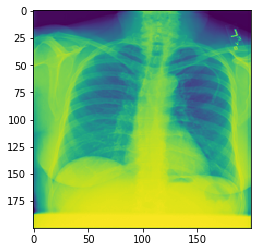

In [16]:
plt.imshow(my_image.squeeze(0));

In [26]:
batch_loader_params = {
    "batch_size": 16,
    "shuffle": True,
    "num_workers": 2
}
dataloader = DataLoader(my_train_set, **batch_loader_params)

In [27]:
# batch_samples = iter(dataloader)
# samples = batch_samples.next()
# datset_batch = torchvision.utils.make_grid(samples['image'])

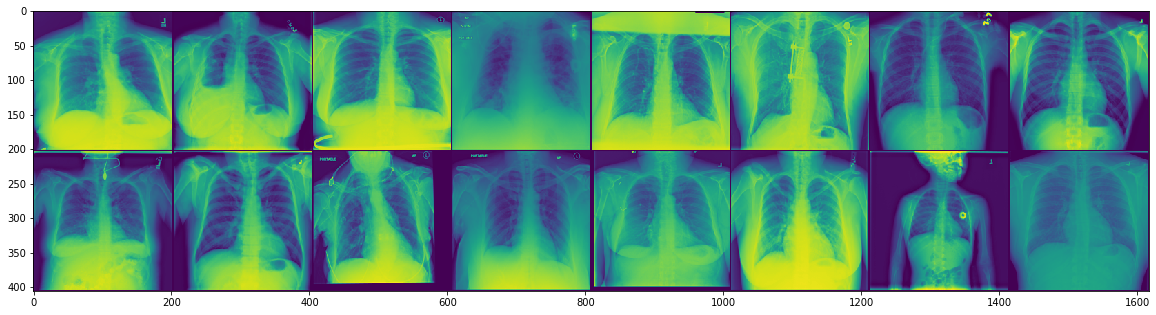

In [29]:
# plt.figure(figsize=(20,10))
# for index, each in enumerate(datset_batch):
#     plt.imshow(each.squeeze(0))

In [20]:
# 1x200x200

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)  # 28x28x4 with batch of 6, 18816
#         self.conv2 = nn.Conv2d(20, 50, 5, 1)
#         self.fc1 = nn.Linear(4*4*50, 60)
#         self.fc2 = nn.Linear(60, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # 24x24x20 with at batch of 6
        return x

In [21]:
net = Net()

In [22]:
def spatial_size(input_size: int, kernel_size: int, stride: int = 1, padding: int = 0):
    # https://cs231n.github.io/convolutional-networks/
    spatial_size = (input_size - kernel_size + 2 * padding)/stride + 1
    assert spatial_size % 1 == 0
    assert spatial_size > 0
    return int(spatial_size)

In [23]:
print(spatial_size(200, 5))

196


In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 100, 5, 1)  
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 60)
        self.fc2 = nn.Linear(60, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
#         x = F.max_pool2d(x, 2, 2) 
#         x = F.relu(self.conv2(x)) 
#         x = F.max_pool2d(x, 2, 2) 
#         x = x.view(-1, 4*4*50)    
#         x = F.relu(self.fc1(x))   
#         x = self.fc2(x)           
        # # There's no activation at the final layer because of the criterion of CEL
        return x


net = Net()

In [ ]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(data['image'])
#         loss = criterion(outputs, data['label'].squeeze())
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()

#     print('[%d, %5d] loss: %.5f' %
#           (epoch + 1, i + 1, running_loss / (epoch*i+1)))